# 프로젝트 DB 기반 노쇼(No-Show) 예측 DNN 실습
이 노트북은 기존의 딥러닝 회귀 모델 구조를 유지하면서, 데이터셋을 프로젝트 DB의 `appointment` 테이블로 교체하여 노쇼 여부를 분류하는 심층 신경망(DNN)을 구축합니다.

In [ ]:
# [필수 라이브러리 임포트]
import pandas as pd                            # 데이터프레임 조작
import seaborn as sns                          # 시각화 도구
import matplotlib.pyplot as plt                # 그래프 출력
import numpy as np                             # 수치 연산
import pysql                                   # DB 접속 모듈
from sklearn.preprocessing import StandardScaler, LabelEncoder # 전처리 도구
from sklearn.model_selection import train_test_split          # 데이터 분할
import torch                                   # 파이토치 핵심 모듈
import torch.nn as nn                          # 신경망 구성 요소
import torch.nn.functional as F                # 활성화 함수
import torch.optim as optim                    # 최적화 알고리즘

c:\Users\s\Documents\2ndnohow\.venv\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\s\Documents\2ndnohow\.venv\Lib\site-packages\paramiko\transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [4]:
# [데이터 로드: 프로젝트 DB 연결 및 데이터 수집]
conn, tunnel = pysql.get_db_connection()       # SSH 터널 및 DB 연결
query = """
    SELECT gender, age, under_12_years_old, over_60_years_old, 
           patient_needs_companion, disability, specialty, no_show 
    FROM appointment
"""
df = pd.read_sql(query, conn)                  # SQL 실행 및 데이터 로드
conn.close()                                   # 연결 종료
tunnel.stop()                                  # 터널 중단

df.head()                                      # 데이터 확인

db connection success


,gender,age,under_12_years_old,over_60_years_old,patient_needs_companion,disability,specialty,no_show
0,0,11,0,0,0,,physiotherapy,1
1,0,11,0,0,0,,psychotherapy,0
2,1,11,0,0,0,,speech therapy,0
3,1,11,0,0,0,,physiotherapy,0
4,0,68,0,1,1,motor,physiotherapy,0


In [5]:
# [데이터 전처리: 범주형 변수 인코딩]
le = LabelEncoder()
for col in ['gender', 'disability', 'specialty']:
    df[col] = le.fit_transform(df[col].astype(str)) # 문자열 데이터를 숫자로 변환

# [피처(X)와 타겟(y) 분리]
X = df.drop(columns="no_show")                 # 입력 데이터 (7개 피처)
y = df['no_show']                             # 출력 데이터 (노쇼 여부)

# [데이터셋 분할: 학습용 80%, 테스트용 20%]
# 수치 설정 유지: test_size=0.2, random_state=42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# [데이터 스케일링: 표준화 수행]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # 학습셋 기준 스케일링
X_test_scaled = scaler.transform(X_test)      # 테스트셋 동일 기준 적용

print(f"X_train shape: {X_train_scaled.shape}, X_test shape: {X_test_scaled.shape}")

X_train shape: (39668, 7), X_test shape: (9918, 7)


In [6]:
# [데이터 타입 변환: Numpy -> PyTorch Tensor]
X_train_tensor = torch.from_numpy(X_train_scaled).float()    # 입력 학습 텐서
X_test_tensor = torch.from_numpy(X_test_scaled).float()      # 입력 테스트 텐서

y_train_tensor = torch.from_numpy(y_train.values).float().view(-1, 1) # 정답(라벨) 학습 텐서
y_test_tensor = torch.from_numpy(y_test.values).float().view(-1, 1)   # 정답(라벨) 테스트 텐서

In [7]:
# [하이퍼파라미터 설정]
# 수치 설정 유지: epochs=5000, lr=0.001
n_epochs = 500         # 학습 반복 횟수
learning_rate = 1e-3    # 학습률
print_interval = 50    # 손실 출력 주기

In [8]:
# [심층 신경망 모델 정의: nn.Sequential]
# 레이어 수치 유지: 입력 -> 64 -> 64 -> 32 -> 출력(1)
model = nn.Sequential(
    nn.Linear(X_train_tensor.size(-1), 64),     # 첫 번째 은닉층
    nn.ReLU(),                                  # 활성화 함수
    
    nn.Linear(64, 64),                          # 두 번째 은닉층
    nn.ReLU(),
    
    nn.Linear(64, 32),                          # 세 번째 은닉층
    nn.ReLU(),
    
    nn.Linear(32, 1),                           # 출력층 (이진 분류)
    nn.Sigmoid()                                # 확률값 도출 (0~1)
)

# [최적화 알고리즘 설정]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# [손실 함수 설정: 이진 교차 엔트로피]
loss_fn = nn.BCELoss()

In [9]:
# [디바이스 설정 및 데이터 이동]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# [학습 루프 실행]
print("학습을 시작합니다...")
for epoch in range(n_epochs):
    model.train()              # 학습 모드 활성화
    
    y_hat = model(X_train_tensor)        # 모델 예측
    loss = loss_fn(y_hat, y_train_tensor)# 오차 계산
    
    optimizer.zero_grad()      # 기울기 초기화
    loss.backward()            # 역전파 수행
    optimizer.step()           # 가중치 업데이트
    
    if (epoch + 1) % print_interval == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}] Loss: {loss.item():.4f}")

print("학습 완료.")

학습을 시작합니다...
Epoch [50/500] Loss: 0.3394
Epoch [100/500] Loss: 0.3231
Epoch [150/500] Loss: 0.3217
Epoch [200/500] Loss: 0.3207
Epoch [250/500] Loss: 0.3200
Epoch [300/500] Loss: 0.3196
Epoch [350/500] Loss: 0.3193
Epoch [400/500] Loss: 0.3188
Epoch [450/500] Loss: 0.3183
Epoch [500/500] Loss: 0.3178
학습 완료.


In [10]:
# [모델 평가: 테스트 데이터 적용]
model.eval()                                    # 평가 모드 전환
with torch.no_grad():                           # 기울기 업데이트 비활성화
    y_pred_probs = model(X_test_tensor)         # 예측 확률값 도출
    y_pred = (y_pred_probs > 0.5).float()       # 0.5 기준 이진 분류
    accuracy = (y_pred == y_test_tensor).float().mean() # 정확도 계산

print(f"Test Accuracy: {accuracy.item():.4f}")

Test Accuracy: 0.9081


In [11]:
pysql.push_model(

    model,
    user_id=5,                                  # 1정유선 2김도영 3유헌상 4정희영 5정용희
    accuracy=f"{accuracy}", 
    description="DNN 테스트"
    
)

db connection success
업로드 완료 (Acc: 0.9081)


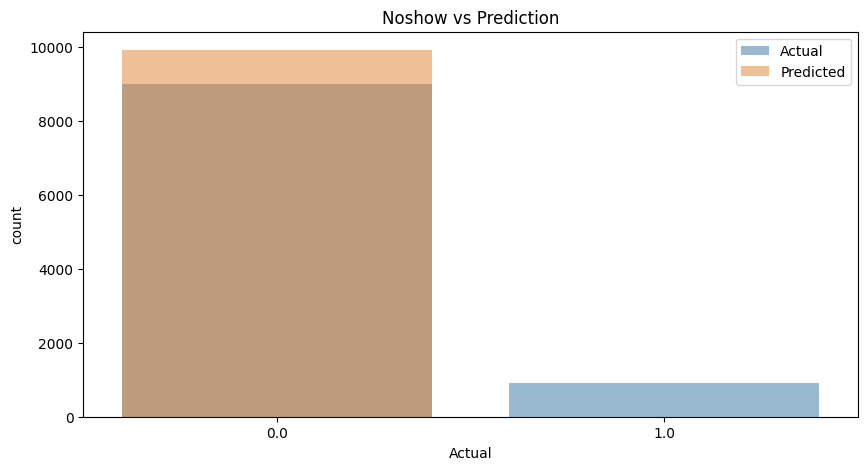

In [12]:
df_result = pd.DataFrame({
    'Actual': y_test_tensor.cpu().view(-1).numpy(),
    'Predicted': y_pred.cpu().view(-1).numpy()
})

plt.figure(figsize=(10, 5))
sns.countplot(x='Actual', data=df_result, alpha=0.5, label='Actual')
sns.countplot(x='Predicted', data=df_result, alpha=0.5, label='Predicted')
plt.title('Noshow vs Prediction')
plt.legend()
plt.show()

In [19]:
# [DB에 누적된 모델 히스토리 확인]
pysql.list_models()                            # 전 팀원의 실험 목록 표 형식 출력

db connection success
번호    | 작성자ID    | 모델유형            | 정확도      | 저장시간                 | 메모
--------------------------------------------------------------------------------------------------------------
35    | 5        | DeepLearning    | 0.9081   | 2026-01-09 03:46:22  | DNN Fix Test
34    | 5        | DeepLearning    | 0.9081   | 2026-01-09 03:45:27  | DNN 테스트
33    | 5        | DeepLearning    | 0.9026   | 2026-01-09 03:41:33  | PyTorch DNN: ERD 정합성 확보 및 7개 변..
32    | 5        | DeepLearning    | 0.9026   | 2026-01-09 03:40:17  | PyTorch DNN: ERD 정합성 확보 및 7개 변..
31    | 3        | MachineLearning | 0.9026   | 2026-01-09 03:39:51  | LightGBM 모델 (유헌상)
30    | 4        | MachineLearning | 0.9026   | 2026-01-09 03:38:18  | XGBoost 모델 테스트
29    | 4        | MachineLearning | 0.9022   | 2026-01-09 03:38:16  | RandomForest 테스트
28    | 3        | MachineLearning | 0.9026   | 2026-01-09 03:37:36  | Logistic Regression 기본 모델 (유헌상..
27    | 5        | MachineLearning | 0.9026   | 2026-01

In [20]:
# [디버깅 버전: 바이너리 정밀 분석 및 로드 시도]

import os
import torch
import numpy as np
import tensorflow as tf
import joblib

# 1. DB에서 데이터 크기 확인
print("🔍 DB 데이터 정밀 분석 중...")
conn, tunnel = pysql.get_db_connection()
target_num = 34

with conn.cursor() as cursor:
    # 데이터의 길이(OCTET_LENGTH)를 함께 조회하여 컬럼 손상 여부 확인
    cursor.execute("SELECT OCTET_LENGTH(model_data), model_data, file_path FROM model WHERE model_num = %s", (target_num,))
    result = cursor.fetchone()

conn.close()
tunnel.stop()

if result:
    data_len, binary_data, original_path = result
    print(f"📊 DB에 기록된 데이터 크기: {data_len:,} bytes")
    
    if data_len < 100:
        print("❌ 경고: 모델 데이터가 너무 작습니다. 저장 과정에서 파일이 비어있었을 수 있습니다.")
    else:
        # 파일 헤더(매직 넘버) 확인
        header = binary_data[:10]
        print(f"📝 데이터 헤더(처음 10바이트): {header}")
        
        file_name = f"debug_{target_num}.bin"
        local_path = os.path.join('data', file_name)
        os.makedirs('data', exist_ok=True)
        
        with open(local_path, 'wb') as f:
            f.write(binary_data)
        
        # [긴급 수수료] PyTorch 모델(ZIP 형태)인지 확인 (PK로 시작함)
        if header.startswith(b'PK'):
            print("📦 포맷 분석: PyTorch(ZIP) 구조로 감지됨")
            try:
                # weights_only=False를 명시적으로 주어 이전 버전 호환성 확보
                model = torch.load(local_path, map_location='cpu', weights_only=False)
                print("✅ PyTorch 모델 로드 성공!")
            except Exception as e:
                print(f"❌ PyTorch 로드 실패: {e}")
        
        # [HDF5 확인] (\x89HDF로 시작함)
        elif header.startswith(b'\x89HDF'):
            print("🗂️ 포맷 분석: Keras(HDF5) 구조로 감지됨")
            try:
                model = tf.keras.models.load_model(local_path)
                print("✅ Keras 모델 로드 성공!")
            except Exception as e:
                print(f"❌ Keras 로드 실패: {e}")
        
        # [Pickle 확인] (\x80로 시작함)
        else:
            print("🧪 포맷 분석: Pickle/Joblib 구조로 추정됨")
            try:
                model = joblib.load(local_path)
                print("✅ Joblib 모델 로드 성공!")
            except Exception as e:
                print(f"❌ Joblib 로드 실패: {e}")

else:
    print("❌ DB에 데이터가 존재하지 않습니다.")

🔍 DB 데이터 정밀 분석 중...
db connection success
📊 DB에 기록된 데이터 크기: 32,835 bytes
📝 데이터 헤더(처음 10바이트): b'PK\x03\x04\x00\x00\x08\x08\x00\x00'
📦 포맷 분석: PyTorch(ZIP) 구조로 감지됨
✅ PyTorch 모델 로드 성공!


In [18]:
# [1단계: 현재 학습된 모델을 DB에 다시 올리기]
import pysql

# 담당자 ID(5)와 실측 정확도(accuracy)를 넣어 새로 업로드합니다.
pysql.push_model(model, user_id=5, accuracy=accuracy.item(), description="DNN Fix Test")

# 업로드 후 출력되는 메시지에서 '새로운 모델 번호'를 확인하세요! (예: 19번 혹은 20번)

db connection success
업로드 완료 (Acc: 0.9081)


In [21]:
# [2단계: 새로 올린 모델로 예측 테스트]
import os
import torch
import numpy as np

# 1. DB에서 모델 가져오기
target_num = 35  # <-- [중요] 방금 새로 생성된 번호로 수정하세요!
print(f"🛰️ DB에서 {target_num}번 모델을 가져옵니다...")

conn, tunnel = pysql.get_db_connection()
with conn.cursor() as cursor:
    cursor.execute("SELECT model_data, file_path FROM model WHERE model_num = %s", (target_num,))
    result = cursor.fetchone()
conn.close()
tunnel.stop()

if result:
    binary_data, _ = result
    # data 폴더에 임시 저장
    local_path = f"data/final_test_{target_num}.pth"
    os.makedirs('data', exist_ok=True)
    with open(local_path, 'wb') as f:
        f.write(binary_data)

    print("🔄 모델 로드 시도...")
    try:
        # PyTorch 모델로 가정하고 로드 (weights_only=False는 필수)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        loaded_model = torch.load(local_path, map_location=device, weights_only=False)
        loaded_model.eval()
        
        # 샘플 예측 (7개 피처)
        dummy_it = torch.zeros((1, 7)).to(device)
        with torch.no_grad():
            prob = loaded_model(dummy_it).item()
            
        print(f"\n✅ 성공! 예측 확률: {prob:.1%}")
        
    except Exception as e:
        print(f"❌ 로드 실패: {e}")
    finally:
        if os.path.exists(local_path): os.remove(local_path)
else:
    print("❌ 모델 데이터를 찾을 수 없습니다.")

🛰️ DB에서 35번 모델을 가져옵니다...
db connection success
🔄 모델 로드 시도...

✅ 성공! 예측 확률: 23.6%
